In [1]:
# dataset
FILENAME = "compounds_ms2structures"

# similarity calculation
MORGAN_RADIUS=9
FINGERPRINT_BITS=4096

# analogue selection
NUM_QUERIES = 1000
GROUP_SIZE=10
SIMILARITY_RANGE=(0.7, 0.9999)
NO_OVERLAP=False
RANDOM_SELECT = True   # Set to false to iterate through the dataset sequentially. Might be be better for high similarity selections.
SEED=42

# unsimilar query selection
MAX_SIMILARITY = 0.15

## Init

In [2]:
import os
import random
random.seed(SEED)
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from rdkit import DataStructs
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import SmilesMolSupplier

from ms_chemical_space_explorer.similarity_maps import get_similarity_map_weights, FingerprintFunction

path = os.path.join( "data", "datasets", FILENAME + ".csv")
fingerprints_file = os.path.join("data", "group_similarity", f"{FILENAME}_fingerprints_morgan{MORGAN_RADIUS}_{FINGERPRINT_BITS}bits.npy")
sim_matrix_file = os.path.join("data", "group_similarity", f"{FILENAME}_ruzicka_similarities_morgan{MORGAN_RADIUS}_{FINGERPRINT_BITS}bits.npy")
df_file = os.path.join("data", "group_similarity", "benchmarks", "backup", f"{FILENAME}_benchmark_num_queries{NUM_QUERIES}_random{int(RANDOM_SELECT)}_size{GROUP_SIZE}_range{SIMILARITY_RANGE}_no_overlap{int(NO_OVERLAP)}_seed{SEED}_morgan{MORGAN_RADIUS}_{FINGERPRINT_BITS}bits.csv")

if FILENAME == "compounds_ms2structures":
    mol_supplier = SmilesMolSupplier(path, delimiter=',', titleLine=True, smilesColumn=1, nameColumn=0)
elif FILENAME == "biostructures_combined":
    mol_supplier = SmilesMolSupplier(path, titleLine=True, nameColumn=0)

# compounds = pd.read_csv(path)
# compounds.head()

## Fingerprints & Similarities

In [3]:
fingerprints = np.load(fingerprints_file, mmap_mode ='r')
sim_matrix = np.load(sim_matrix_file, mmap_mode ='r')

print(fingerprints.shape, sim_matrix.shape)

(37811, 4096) (37811, 37811)


## Load benchmark with similar groups

In [4]:
def str_to_list_of_ints(series):
    return [int(x) for x in series.strip("[]").split(",") if x.strip().isdigit()]


analogue_df = pd.read_csv(df_file, index_col=0)
analogue_df["analogue_ids"] = analogue_df["analogue_ids"].apply(str_to_list_of_ints)
print(f"Found {df_file}\nLoaded {len(analogue_df)} analogue groups.")
analogue_df

Found data\group_similarity\benchmarks\backup\compounds_ms2structures_benchmark_num_queries1000_random1_size10_range(0.7, 0.9999)_no_overlap0_seed42_morgan9_4096bits.csv
Loaded 1000 analogue groups.


,analogue_ids,query_sim,group_sim,sgs,sgs_score,query_id_unsimilar,query_sim_unsimilar,sgs_score_unsimilar,query_mean_weights
query_id,,,,,,,,,
35713,"[23200, 15235, 23492, 16509, 788, 36440, 6612,...",0.757227,0.651649,0.718469,0.958369,7296.0,0.048941,0.495740,0.745032
6698,"[4956, 18407, 36935, 14442, 34068, 12344, 9297...",0.728808,0.741461,0.711796,0.930022,1639.0,0.034004,0.529015,0.699278
23723,"[6469, 4900, 21458, 21338, 4110, 2985, 4580, 3...",0.776946,0.714194,0.768828,0.958988,18024.0,0.019481,0.433941,0.779438
23219,"[34068, 19889, 23098, 30328, 4192, 27915, 4203...",0.764761,0.679330,0.671523,0.952904,16049.0,0.046053,0.593117,0.690729
7161,"[6420, 34482, 15048, 9393, 8816, 6018, 14039, ...",0.752489,0.651582,0.704055,0.949291,14628.0,0.032426,0.504996,0.736315
...,...,...,...,...,...,...,...,...,...
9389,"[13371, 16668, 1846, 4964, 12, 26636, 25711, 3...",0.856211,0.793353,0.725266,0.981181,29804.0,0.012239,0.555282,0.724871
34088,"[16501, 19951, 7447, 20032, 33526, 11214, 2076...",0.793224,0.726373,0.781378,0.950357,24155.0,0.017810,0.413372,0.760490
26225,"[8055, 31010, 7549, 29135, 276, 7567, 27413, 3...",0.754275,0.703045,0.700822,0.937447,17181.0,0.028164,0.524335,0.721508


## Benchmark

In [5]:
analogue_df.analogue_ids[35713]

[23200, 15235, 23492, 16509, 788, 36440, 6612, 29122, 12150, 18256]

In [6]:
def pick_unsimilar_query(group_ids, sim_matrix, max_similarity_threshold):
    sims =[]
    used_queries = []
    
    query_id = random.randint(0, len(sim_matrix) - 1)
    found_unsimilar_query = False
    while found_unsimilar_query == False:
        # pick unused query
        while query_id in used_queries:
            query_id = random.randint(0, len(sim_matrix) - 1)
        used_queries.append(query_id)
        
        # get similarities to group
        sims = []
        for group_id in group_ids:
            sims.append(sim_matrix[query_id, group_id])
        
        # check if query is unsimilar enough
        if np.max(sims) < max_similarity_threshold:
            break
    
    return query_id, sims

In [ ]:
def get_unsimilar_benchmark(df_file, analogue_df, sim_matrix, mol_supplier, morgan_radius, fpSize,  max_similarity_threshold):
    try:
        print(f"Trying to load benchmark dataframe from {df_file}")
        analogue_df = pd.read_csv(df_file, index_col=0)
        analogue_df["analogue_ids"] = analogue_df["analogue_ids"].apply(str_to_list_of_ints)
        print(f"Found {df_file}\nTrying to access benchmark columns.\nExisting columns: {analogue_df.columns.tolist()}")
        query_sim_unsimilar= analogue_df[:1].query_sim_unsimilar
        sgs_score_unsimilar=analogue_df[:1].sgs_score_unsimilar
        print(f"Benchmark found! Loaded benchmark for {len(analogue_df)} queries.")
    except Exception as e:
        print(f"Benchmark not found: {df_file}\nRunning the benchmark dataframe generation.")
        # generate benchmark dataframe
        fp_function = FingerprintFunction(fingerprint="MORGAN")
        fp_function.fp_type = "count"
        fp_function.morgan_radius = morgan_radius
        fp_function.nbits = fpSize

        for query_id, row in tqdm(analogue_df.iterrows(), desc="Processing queries", total=len(analogue_df)):
            analogue_ids = [int(x) for x in row["analogue_ids"]]
            query_id_unsimilar, query_sims_unsimilar = pick_unsimilar_query(analogue_ids, sim_matrix, max_similarity_threshold)
            analogue_df.loc[query_id, 'query_id_unsimilar'] = query_id_unsimilar
            analogue_df.loc[query_id, 'query_sim_unsimilar'] = np.mean(query_sims_unsimilar)

            query = mol_supplier[query_id_unsimilar]
            
            query_sims = []
            stacked_mean_weights = []
            query_scaled_inverted_differnces = []
            for ref_id in tqdm(analogue_ids, desc=f"Processing analogues for query {query_id_unsimilar}", leave=False):
                # gather ruzicka similarity of analogue vs query
                query_sims.append(sim_matrix[query_id_unsimilar][ref_id])
                
                # generate the reference molecule
                ref_analogue = mol_supplier[ref_id]
                
                # create array for stacked weights
                stacked_atomic_weights = [0] * ref_analogue.GetNumAtoms()
                
                # compute the group similarity map weights
                for probe_id in analogue_ids:#tqdm(analogue_ids, desc=f"Computing weights for weights for analogue {ref_id}", leave=False):
                    if ref_id == probe_id:
                        continue
                    
                    probe_analogue = mol_supplier[probe_id]

                    # extract and standardize similarity weights for the reference molecule
                    ref_sim_weights = SimilarityMaps.GetAtomicWeightsForFingerprint(probe_analogue, ref_analogue, fp_function.get_function, metric=DataStructs.TanimotoSimilarity) #this is the bottle neck
                    #print(f"Getting weights took {(pd.Timestamp.now() - getting_weights_start).total_seconds():.4f} seconds")

                    # stack the weights
                    stacked_atomic_weights = [stacked_atomic_weights[i] + ref_sim_weights[i] for i in range(ref_analogue.GetNumAtoms())]
                # Standardize the stacked weights
                stacked_atomic_weights, _ = SimilarityMaps.GetStandardizedWeights(stacked_atomic_weights)
                stacked_mean_weights.append(sum(stacked_atomic_weights) / len(stacked_atomic_weights))
                
                # compute the similarity map weights against the query molecule
                query_atomic_weights = get_similarity_map_weights(ref_analogue, query, fp_function)
                
                # calculate absolute weight difference for each atom against the query
                query_abs_differences = ([abs(stacked_atomic_weights[i] - query_atomic_weights[i]) for i in range(len(stacked_atomic_weights))])
                query_mean_difference = sum(query_abs_differences) / len(query_abs_differences)
                
                # scale and invert the mean absolute difference to get a similarity score
                query_scaled_inverted_differnce = 1 - (query_mean_difference * 0.5)
                query_scaled_inverted_differnces.append(query_scaled_inverted_differnce)
            # --- gather all similarity metrics ---
            # mean ruzicka similarity of analogue vs query ruzicka similaities
            analogue_df.loc[query_id, "query_sim"] = np.mean(query_sims)
            
            # # # mean of all-vs-all analogue ruzicka similarities
            # fp_group_sim_matrix = ruzicka_similarity_matrix(fingerprints[analogue_ids], fingerprints[analogue_ids])
            # group_sim = off_diagonal_mean(fp_group_sim_matrix)
            # analogue_df.loc[query_id, "group_sim"] = group_sim
            
            # # mean of the means of stacked atomic weights of all-vs-all analogue similarity maps
            # unscaled_sgs = np.mean(stacked_mean_weights)                # range [-1, 1]
            # analogue_df.loc[query_id, "sgs"] = (unscaled_sgs + 1) / 2   # range [0, 1]
            
            # scaled and inverted mean of the means of the absolute differences between atomic stacked weights and atomic query weights
            sgs_score = (sum(query_scaled_inverted_differnces) / len(query_scaled_inverted_differnces))
            analogue_df.loc[query_id, "sgs_score_unsimilar"] = sgs_score

        analogue_df.to_csv(df_file)
        print(f"Saved {len(analogue_df)} queries to {df_file}.")
    return analogue_df

In [8]:
analogue_df = get_unsimilar_benchmark(df_file, analogue_df, sim_matrix, mol_supplier, MORGAN_RADIUS, FINGERPRINT_BITS, MAX_SIMILARITY)

Trying to load benchmark dataframe from data\group_similarity\benchmarks\backup\compounds_ms2structures_benchmark_num_queries1000_random1_size10_range(0.7, 0.9999)_no_overlap0_seed42_morgan9_4096bits.csv
Found data\group_similarity\benchmarks\backup\compounds_ms2structures_benchmark_num_queries1000_random1_size10_range(0.7, 0.9999)_no_overlap0_seed42_morgan9_4096bits.csv
Trying to access benchmark columns.
Existing columns: ['analogue_ids', 'query_sim', 'group_sim', 'sgs', 'sgs_score', 'query_id_unsimilar', 'query_sim_unsimilar', 'sgs_score_unsimilar', 'query_mean_weights']
Benchmark found! Loaded benchmark for 1000 queries.


dissim_file = os.path.join("data", "group_similarity", "benchmarks", "backup", f"{FILENAME}_benchmark_num_queries{NUM_QUERIES}_random{int(RANDOM_SELECT)}_size{GROUP_SIZE}_range{SIMILARITY_RANGE}_no_overlap{int(NO_OVERLAP)}_seed{SEED}_morgan{MORGAN_RADIUS}_{FINGERPRINT_BITS}bits.csv")

dissim_df = pd.read_csv(dissim_file, index_col=0)
dissim_df["analogue_ids"] = dissim_df["analogue_ids"].apply(str_to_list_of_ints)

analogue_df = pd.read_csv(df_file, index_col=0)
analogue_df["analogue_ids"] = analogue_df["analogue_ids"].apply(str_to_list_of_ints)

In [9]:
analogue_df.drop(columns=["analogue_ids", "query_id_unsimilar", "query_sim", "sgs_score", "query_mean_weights"], inplace=True)


In [10]:
cols = analogue_df.columns.tolist()
cols.remove('query_sim_unsimilar')
cols.insert(0, 'query_sim_unsimilar')
analogue_df = analogue_df[cols]

In [11]:
analogue_df.describe()

,query_sim_unsimilar,group_sim,sgs,sgs_score_unsimilar
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.033895,0.735464,0.738398,0.491314
std,0.022050,0.045664,0.031290,0.056313
min,0.000000,0.623999,0.619026,0.378090
25%,0.020092,0.701849,0.720571,0.452948
50%,0.029506,0.731256,0.735877,0.484230
75%,0.040616,0.766433,0.760394,0.519336
max,0.136147,0.903892,0.816185,0.790356


In [12]:
analogue_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 35713 to 26268
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   query_sim_unsimilar  1000 non-null   float64
 1   group_sim            1000 non-null   float64
 2   sgs                  1000 non-null   float64
 3   sgs_score_unsimilar  1000 non-null   float64
dtypes: float64(4)
memory usage: 39.1 KB


In [13]:
analogue_df.describe()

,query_sim_unsimilar,group_sim,sgs,sgs_score_unsimilar
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.033895,0.735464,0.738398,0.491314
std,0.022050,0.045664,0.031290,0.056313
min,0.000000,0.623999,0.619026,0.378090
25%,0.020092,0.701849,0.720571,0.452948
50%,0.029506,0.731256,0.735877,0.484230
75%,0.040616,0.766433,0.760394,0.519336
max,0.136147,0.903892,0.816185,0.790356


<Axes: >

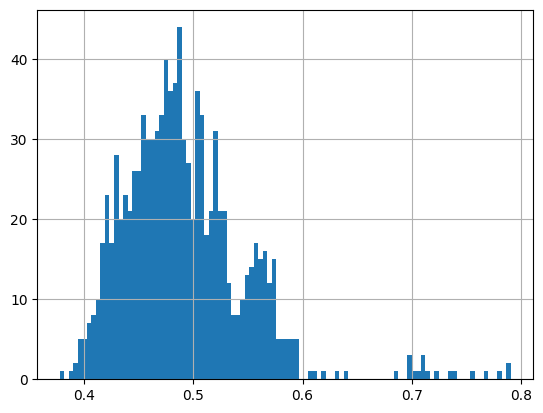

In [14]:
analogue_df.sgs_score_unsimilar.hist(bins=100)#, range=(xmin, xmax)).set_ylim(top=ymax)

In [15]:
analogue_df.sgs_score_unsimilar.quantile(0.99)

0.7113054889526499

In [16]:
analogue_df.columns = ['query sim unsimilar', 'group sim', 'sgs', 'sgs score unsimilar']

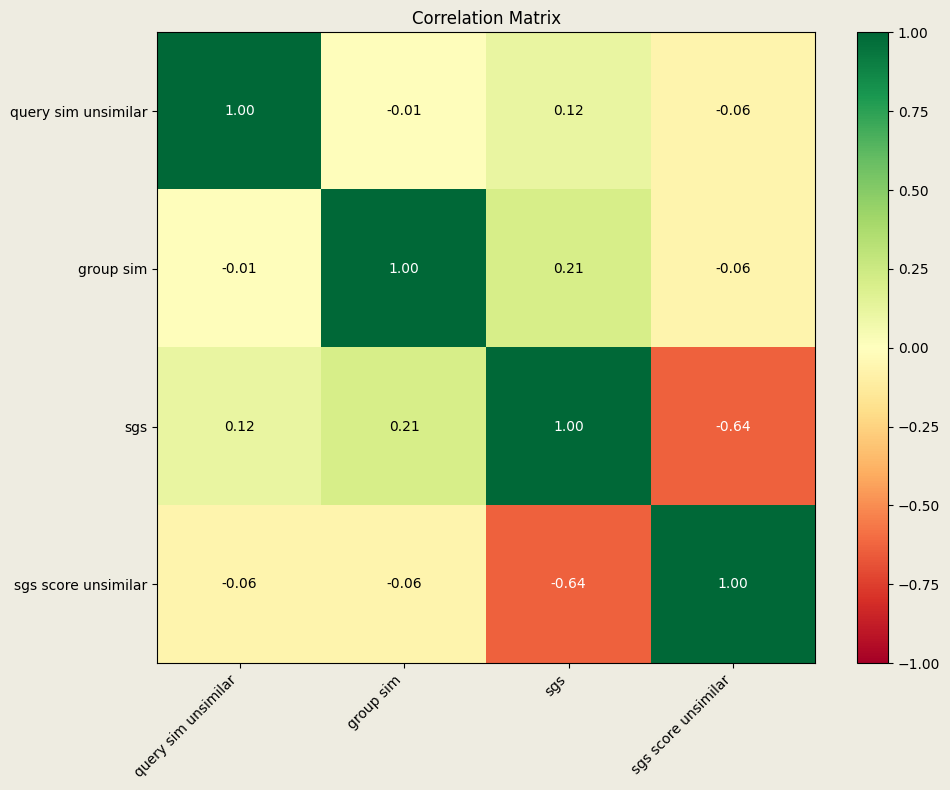

In [17]:

import matplotlib.pyplot as plt

# Create correlation matrix heatmap without seaborn
fig, ax = plt.subplots(figsize=(10, 8))
corr_matrix = analogue_df.corr()
fig.set_facecolor("#EEECE1")

# Create heatmap using matplotlib
im = ax.imshow(corr_matrix, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)

# Add colorbar
plt.colorbar(im)

# Set ticks and labels
ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_yticks(range(len(corr_matrix.index)))
ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
ax.set_yticklabels(corr_matrix.index)

# Add correlation values as text
for i in range(len(corr_matrix.index)):
    for j in range(len(corr_matrix.columns)):
        text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                      ha="center", va="center", color="black" if abs(corr_matrix.iloc[i, j]) < 0.5 else "white")

plt.title(f"Correlation Matrix")
plt.tight_layout()
plt.show()

In [18]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [19]:
colors = ['#1f77b4',
 #'#ff7f0e',    this is query_mean_weiths in the other figures
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

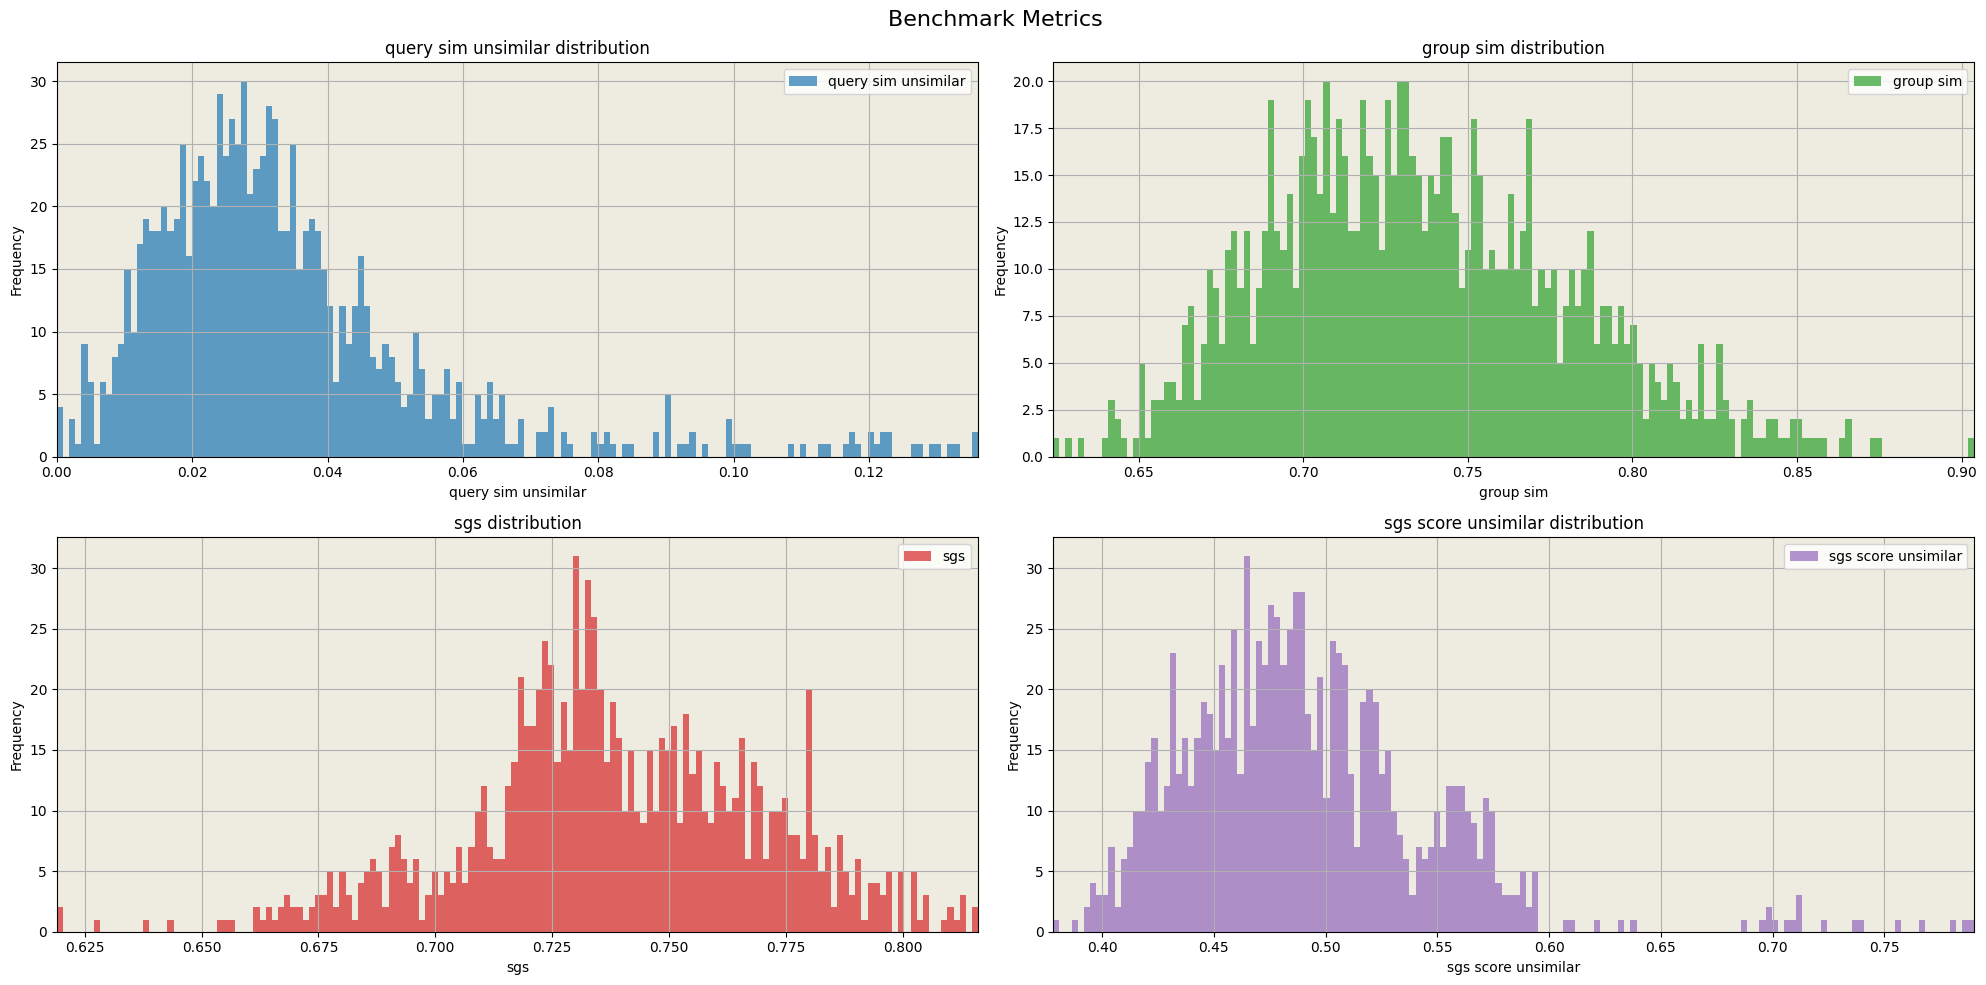

In [20]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Create a figure with subplots for animation
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()

global_y_max = 25
bins = 150
global_y_maxes = {}
global_x_ranges = {}

for column in analogue_df.columns:
    column_max = 0
    data = analogue_df[column].dropna()
    if len(data) > 0:
        counts, _ = np.histogram(data, bins=bins)
        column_max = max(column_max, max(counts))
    
    global_y_maxes[column] = column_max if column_max > 0 else 25
    
    all_values = analogue_df[column].dropna().values
    global_x_ranges[column] = {
        'min': min(all_values),
        'max': max(all_values)
    }

# Clear all subplots
for ax in axes:
    ax.clear()

# Set the main title
fig.suptitle(f"Benchmark Metrics", fontsize=16)

# Plot each metric
for i, column in enumerate(analogue_df.columns):
    ax = axes[i]
    
    # Use consistent colors
    color = colors[i % len(colors)]
    
    # Get data and filter NaN values
    data = analogue_df[column].dropna()
    
    if len(data) > 0:
        ax.hist(data, bins=bins, alpha=0.7, label=f"{column}", color=color)
    
    # Set consistent axis limits
    ax.set_xlim(global_x_ranges[column]['min'], global_x_ranges[column]['max'])
    ax.set_ylim(0, global_y_maxes[column] * 1.05)  # Add 5% padding
    ax.set_facecolor("#EEECE1")
    
    ax.set_xlabel(column)
    ax.set_ylabel("Frequency")
    ax.grid(True)
    ax.set_title(f"{column} distribution")
    ax.legend()

# Create animation
plt.tight_layout()
plt.show()
plt.close(fig)  # Close the figure to avoid displaying it twice in Jupyter